####For Mncs listed below.

In [1]:
!pip install qwikidata
!pip install "tensorflow-gpu>=1.14.0,<2.0" # ampligraph only works with tensorflow 1.
!pip install ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for qwikidata: filename=qwikidata-0.4.2-py3-none-any.whl size=24884 sha256=195ede771d9a590058a3602b842b5df2ca10b5e8387363ce43f74a6a836687c1
  Stored in directory: /root/.cache/pip/wheels/2c/55/24/b725ba845ebcf3a8fcdf0583dec824218ee9e4e63c59cb9171
Successfully built qwikidata
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu<2.0,>=1.14.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No match

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

KG_companies = ["Facebook", "Amazon", "Apple Inc.", "Netflix", "Google"]

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
from tqdm.notebook import tqdm

def get_triples_from_wikidata(companies_list, predicate_list):
    """
    Inputs: companies_list - a list of companies, identified by their Q id.
            predicate_list - a list of predicates, identified by their P id.
    Outputs: (company, predicate, object) triples.
            E.g. (Tesla, CEO, Elon Musk)
    """
    subjects, predicates, objects = [], [], []
    for Q_id in tqdm(companies_list):
        Q_company = WikidataItem(get_entity_dict_from_api(Q_id))
        for predicate in predicate_list:
            for claim in Q_company.get_claim_group(predicate):
                object_id = claim.mainsnak.datavalue.value["id"]
                object_entity = WikidataItem(get_entity_dict_from_api(object_id))

                subjects.append(Q_company.get_label())

                predicate_property = WikidataProperty(get_entity_dict_from_api(predicate))
                predicates.append(predicate_property.get_label()) 

                objects.append(object_entity.get_label())

    return subjects, predicates, objects  

In [4]:
## On wikidata
companies_list = ["Q355", "Q3884", "Q312", "Q907311", "Q95"]
predicate_list = ["P31", "P17", "P361", "P452", "P112", "P169", "P463", "P355", "P1830", "P1056"]

In [5]:
subjects, predicates, objects = get_triples_from_wikidata(companies_list, predicate_list)
wiki_triples_df = pd.DataFrame({"subject": subjects, "predicate": predicates, "object": objects})

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
wiki_triples_df.sample(10)

subject                     predicate  \
161   Apple                     member of   
295  Google                has subsidiary   
117  Amazon  product or material produced   
272  Google                has subsidiary   
141   Apple                    founded by   
253  Google                     member of   
162   Apple                     member of   
371  Google                      owner of   
75   Amazon                      owner of   
37   Amazon                has subsidiary   

                                                object  
161                                     Initiative D21  
295                                 dMarc Broadcasting  
117                                      Amazon Kindle  
272                                               Waze  
141                                      Steve Wozniak  
253                          World Wide Web Consortium  
162  Zentralverband Elektrotechnik- und Elektroniki...  
371                                 Google Cloud Print  
75                                           Amazon S3  
37                                      Alexa Internet

In [7]:
wiki_triples = []
for index, row in wiki_triples_df.iterrows():
    wiki_triples.append((row.subject, row.predicate, row.object))

In [8]:
import networkx as nx
def create_graph(col):
    graph = nx.from_pandas_edgelist(wiki_triples_df[wiki_triples_df.subject == str(col)], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(graph)
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    nx.draw_networkx_edge_labels(graph, pos=pos)
    plt.show()

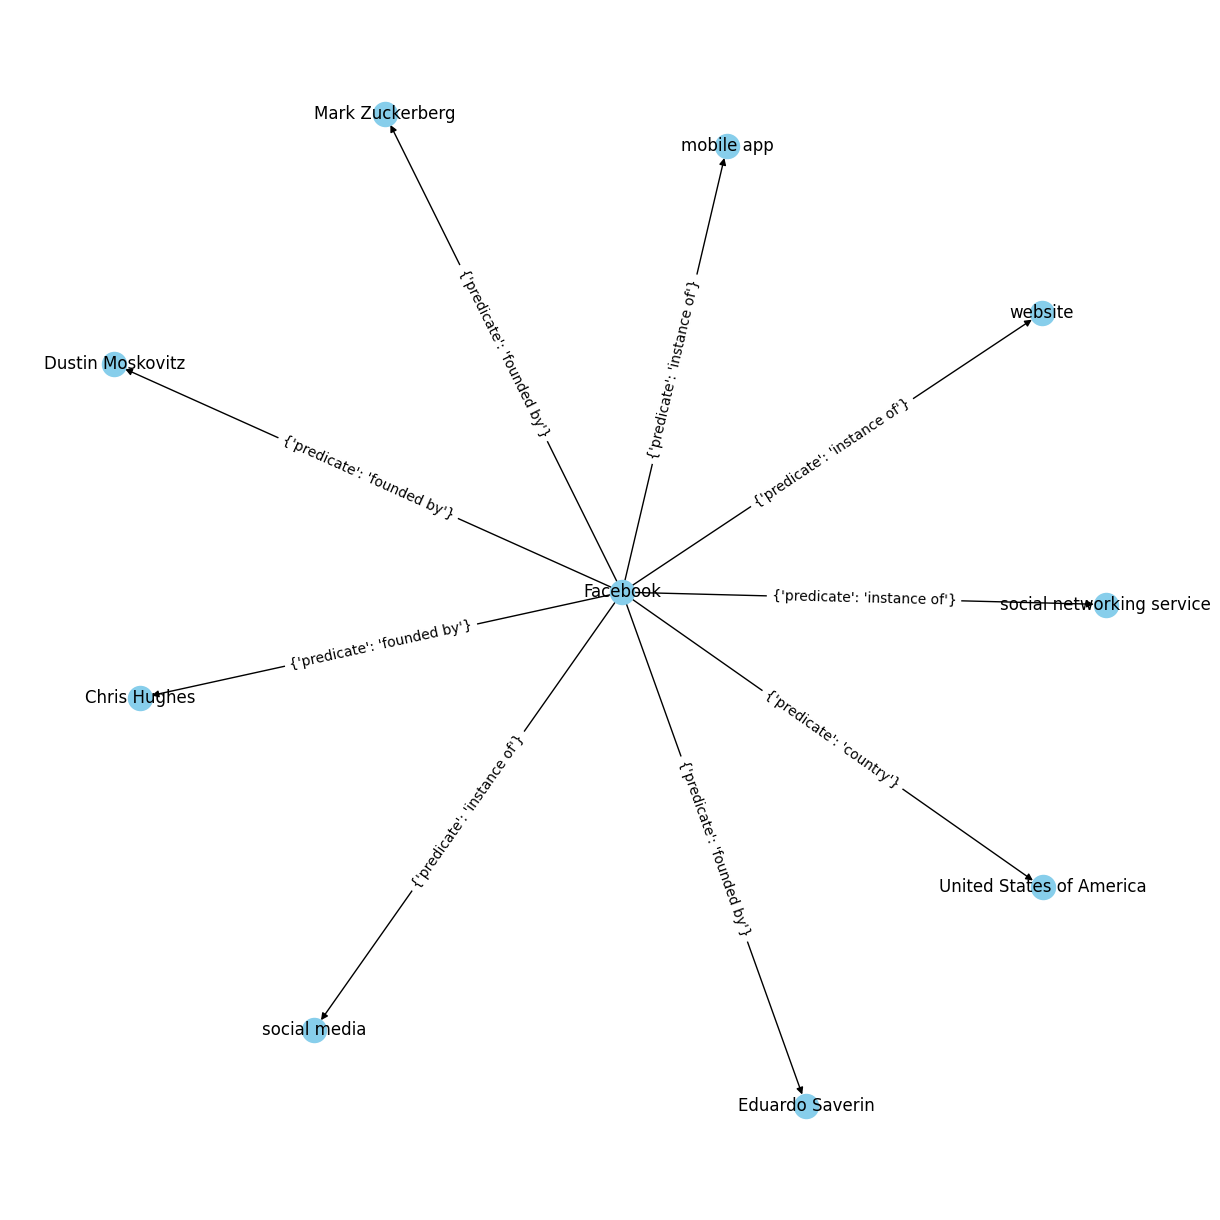

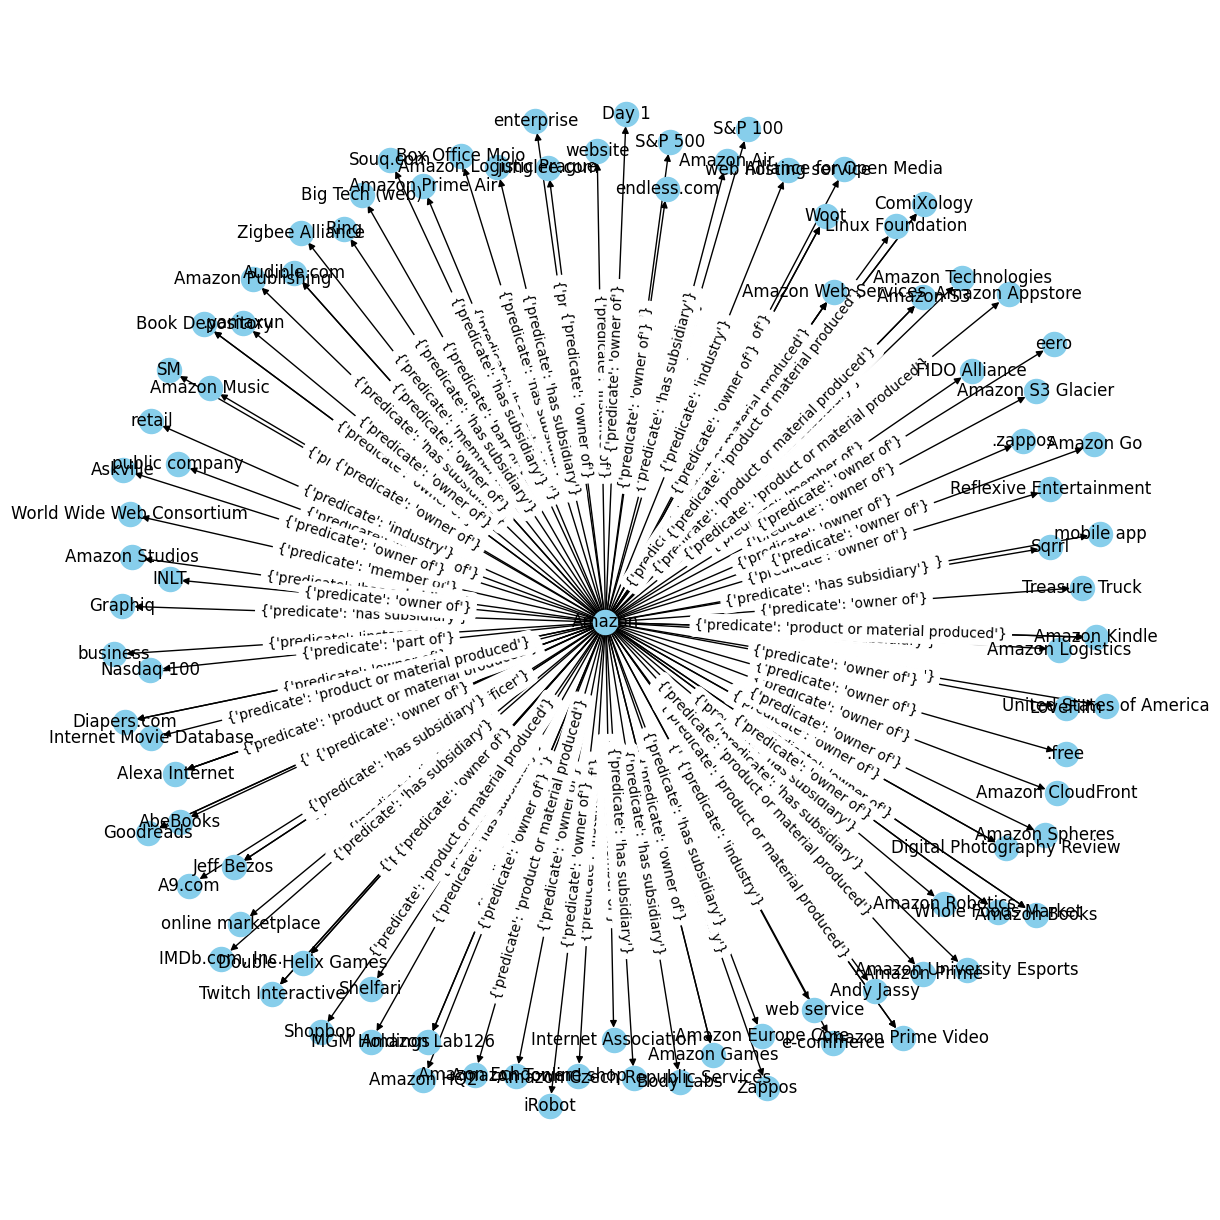

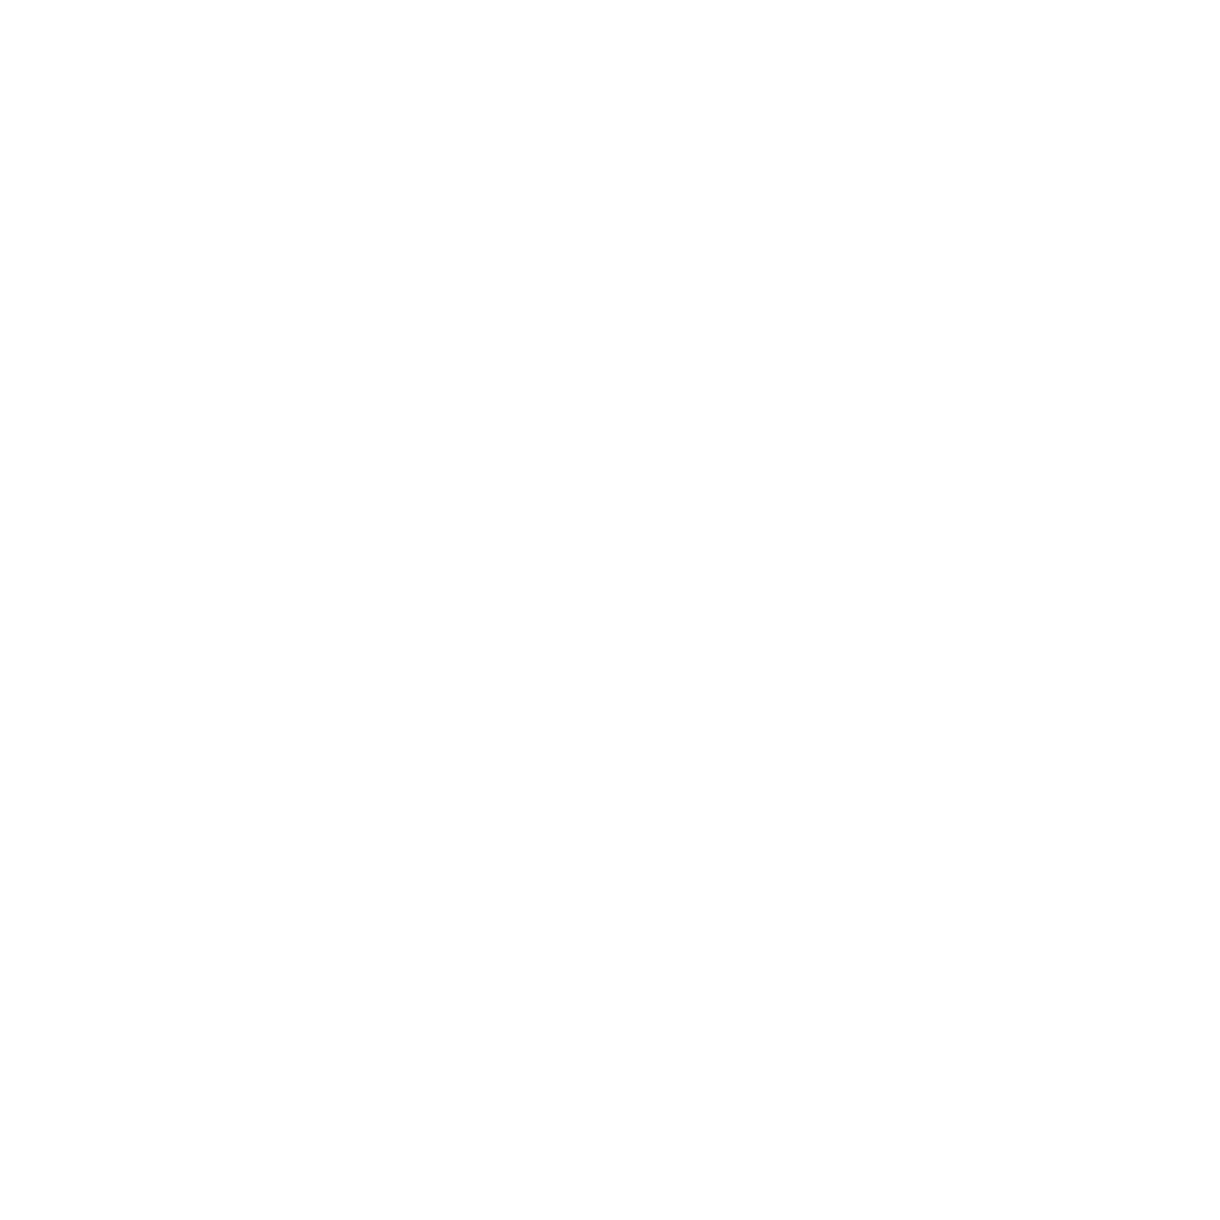

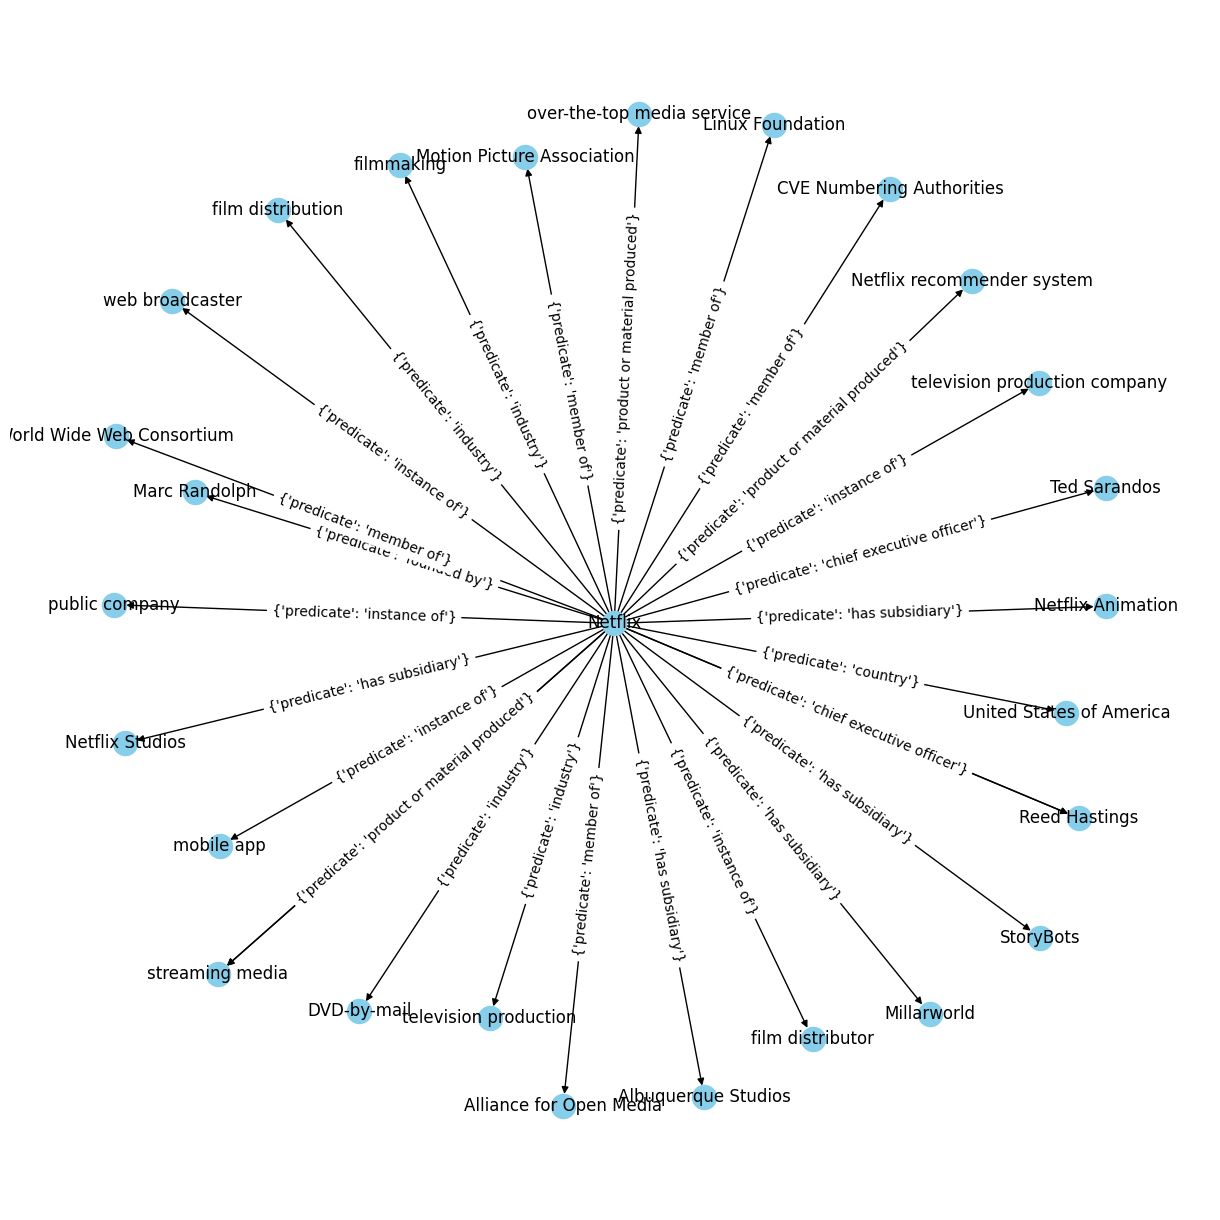

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


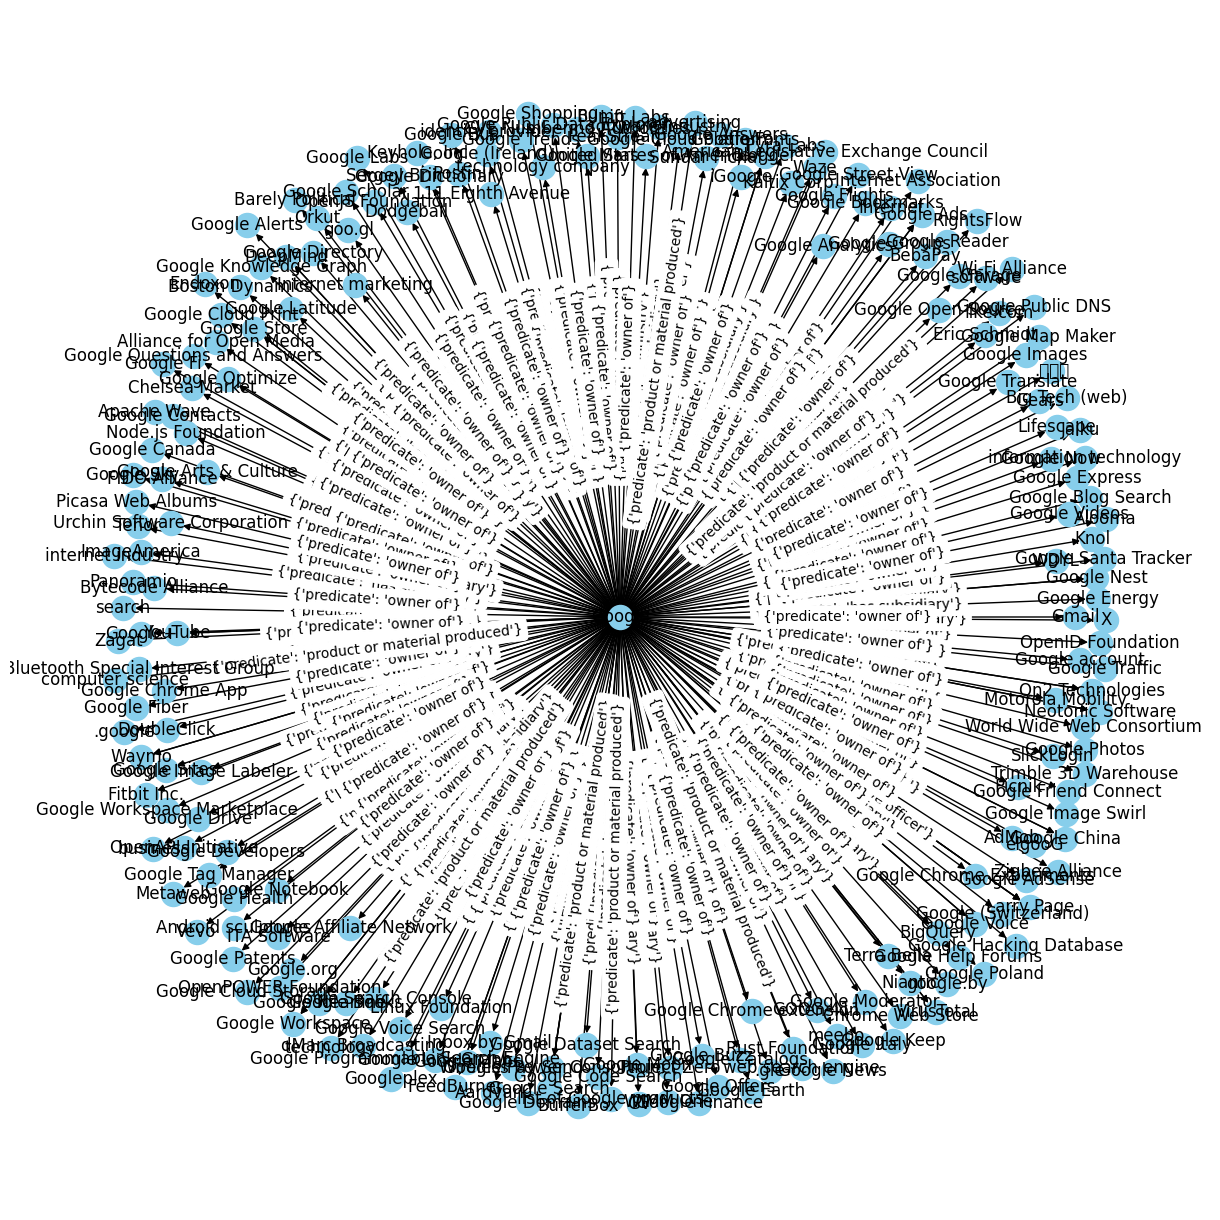

In [9]:
for comp in KG_companies:
    create_graph(comp)

####Twitter Data

In [14]:
!unzip /content/test.csv.zip
!unzip /content/train1.csv.zip

Archive:  /content/train1.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [13]:
import numpy as np 
import pandas as pd
import os
import warnings
import re
import string
warnings.filterwarnings("ignore")
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop= stopwords.words('english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemm= WordNetLemmatizer()
from textblob import TextBlob
import bs4
import requests
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
%%time
#using pandas to read the train and test file 
train= pd.read_csv('/content/train.csv', encoding="ISO-8859-1")
test=pd.read_csv('/content/test.csv', encoding="ISO-8859-1")
df= pd.concat([train,test])
print("Train data frame shape:",train.shape)
print("Test data frame shape:",test.shape)
print("Complete data frame shape:",df.shape)

Train data frame shape: (31962, 3)
Test data frame shape: (17197, 2)
Complete data frame shape: (49159, 3)
CPU times: user 105 ms, sys: 18 ms, total: 123 ms
Wall time: 122 ms


In [16]:
df.head()

id  label                                              tweet
0   1    0.0   @user when a father is dysfunctional and is s...
1   2    0.0  @user @user thanks for #lyft credit i can't us...
2   3    0.0                                bihday your majesty
3   4    0.0  #model   i love u take with u all the time in ...
4   5    0.0             factsguide: society now    #motivation

In [18]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [19]:
df['tweet']= df["tweet"].str.lower()
df.head()

id  label                                              tweet
0   1    0.0   @user when a father is dysfunctional and is s...
1   2    0.0  @user @user thanks for #lyft credit i can't us...
2   3    0.0                                bihday your majesty
3   4    0.0  #model   i love u take with u all the time in ...
4   5    0.0             factsguide: society now    #motivation

In [20]:
df['tweet']=df['tweet'].str.replace("<[^<]+?>","",regex=True)
df.head()

id  label                                              tweet
0   1    0.0   @user when a father is dysfunctional and is s...
1   2    0.0  @user @user thanks for #lyft credit i can't us...
2   3    0.0                                bihday your majesty
3   4    0.0  #model   i love u take with u all the time in ...
4   5    0.0             factsguide: society now    #motivation

In [21]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / I will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",  
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

cont_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return cont_re.sub(replace, s)
df['tweet'] =df['tweet'].apply(expand)
df.head()

id  label                                              tweet
0   1    0.0   @user when a father is dysfunctional and is s...
1   2    0.0  @user @user thanks for #lyft credit i cannot u...
2   3    0.0                                bihday your majesty
3   4    0.0  #model   i love u take with u all the time in ...
4   5    0.0             factsguide: society now    #motivation

In [22]:
#Remove http and url
df['tweet']=df['tweet'].str.replace('https?://\S+|www\.\S+', '',regex=True)
#Remove punctuations and 
df['tweet']=df['tweet'].str.replace('[%s]' % re.escape(string.punctuation), '', regex=True)
#lets remove new line characters if any
df['tweet']=df['tweet'].str.replace('\n', '', regex=True)
df.head()

id  label                                              tweet
0   1    0.0   user when a father is dysfunctional and is so...
1   2    0.0  user user thanks for lyft credit i cannot use ...
2   3    0.0                                bihday your majesty
3   4    0.0  model   i love u take with u all the time in u...
4   5    0.0               factsguide society now    motivation

In [23]:
#for this analysis, I am removing the emojis
def emojis(text):
    emoji = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

df['tweet']=df['tweet'].apply(lambda x: emojis(x))
df.head()

id  label                                              tweet
0   1    0.0   user when a father is dysfunctional and is so...
1   2    0.0  user user thanks for lyft credit i cannot use ...
2   3    0.0                                bihday your majesty
3   4    0.0  model   i love u take with u all the time in u...
4   5    0.0               factsguide society now    motivation

In [24]:
df['tweet'].apply(lambda x: [item for item in x if item not in stop])
df.head()

id  label                                              tweet
0   1    0.0   user when a father is dysfunctional and is so...
1   2    0.0  user user thanks for lyft credit i cannot use ...
2   3    0.0                                bihday your majesty
3   4    0.0  model   i love u take with u all the time in u...
4   5    0.0               factsguide society now    motivation

In [25]:
def lemmatization(df):
    df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df.head()

id  label                                              tweet
0   1    0.0   user when a father is dysfunctional and is so...
1   2    0.0  user user thanks for lyft credit i cannot use ...
2   3    0.0                                bihday your majesty
3   4    0.0  model   i love u take with u all the time in u...
4   5    0.0               factsguide society now    motivation

In [26]:
df['tweet']=df['tweet'].str.replace('user', '',regex=True)
df.head()

id  label                                              tweet
0   1    0.0    when a father is dysfunctional and is so sel...
1   2    0.0    thanks for lyft credit i cannot use cause th...
2   3    0.0                                bihday your majesty
3   4    0.0  model   i love u take with u all the time in u...
4   5    0.0               factsguide society now    motivation

In [27]:
#Restricting graph to 5000 tweets only
tweets=df['tweet'][:5000]

In [28]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text


  return [ent1.strip(), ent2.strip()]

In [29]:
entity_pairs = []

for i in tqdm(tweets):
  entity_pairs.append(get_entities(i))

entity_pairs[10:20]

100%|██████████| 5000/5000 [01:00<00:00, 82.99it/s]


[['price index mom', 'silver gold forex'],
 ['we', 'orlandoshooting orlando values'],
 ['today 80days', 'daddy'],
 ['cnn', 'wall chant tcot'],
 ['comment', 'opkillingbay seashepherd helpcovedolphins'],
 ['ouchjunior', ''],
 ['i', 'thankful  positive'],
 ['you', ''],
 ['smiles', 'around ig people'],
 ['essential  oils', 'chemicals']]

In [ ]:
doc = nlp("ii")
    # Matcher class object 
matcher = Matcher(nlp.vocab)
matcher.add()

NameError: ignored

In [38]:
def predicates(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern],on_match=None) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [44]:
predicates = [predicates(i) for i in tqdm(tweets[:2200])]






  0%|          | 0/2200 [00:00<?, ?it/s]




  0%|          | 10/2200 [00:00<00:23, 93.54it/s]




  1%|          | 21/2200 [00:00<00:21, 101.86it/s]




  1%|▏         | 32/2200 [00:00<00:32, 66.13it/s] 




  2%|▏         | 40/2200 [00:00<00:39, 54.76it/s]




  2%|▏         | 49/2200 [00:00<00:34, 62.20it/s]




  3%|▎         | 58/2200 [00:00<00:31, 68.80it/s]




  3%|▎         | 67/2200 [00:00<00:28, 74.20it/s]




  3%|▎         | 76/2200 [00:01<00:28, 75.55it/s]




  4%|▍         | 86/2200 [00:01<00:26, 80.82it/s]




  4%|▍         | 96/2200 [00:01<00:25, 84.00it/s]




  5%|▍         | 107/2200 [00:01<00:23, 89.02it/s]




  5%|▌         | 118/2200 [00:01<00:22, 92.68it/s]




  6%|▌         | 129/2200 [00:01<00:21, 95.68it/s]




  6%|▋         | 139/2200 [00:01<00:22, 90.57it/s]




  7%|▋         | 150/2200 [00:01<00:21, 93.28it/s]




  7%|▋         | 160/2200 [00:01<00:21, 94.26it/s]




  8%|▊         | 170/2200 [00:02<00:24, 83.07it/s]




  8%|▊         | 179/22

In [45]:
pd.Series(predicates).value_counts()[:10]

is             114
has             58
am thankful     32
are             32
âââã         27
love            25
have            25
be              23
am              23
got             21
dtype: int64

In [47]:
# extract subject
subject = [i[0] for i in entity_pairs]

# extract object
object1 = [i[1] for i in entity_pairs]

graph_df = pd.DataFrame({'subject':subject[:2200],  'predicate':predicates, 'object':object1[:2200]})

In [48]:
# create a directed-graph from a dataframe
graph=nx.from_pandas_edgelist(graph_df, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

 44%|████▍     | 2225/5000 [03:32<04:25, 10.46it/s]


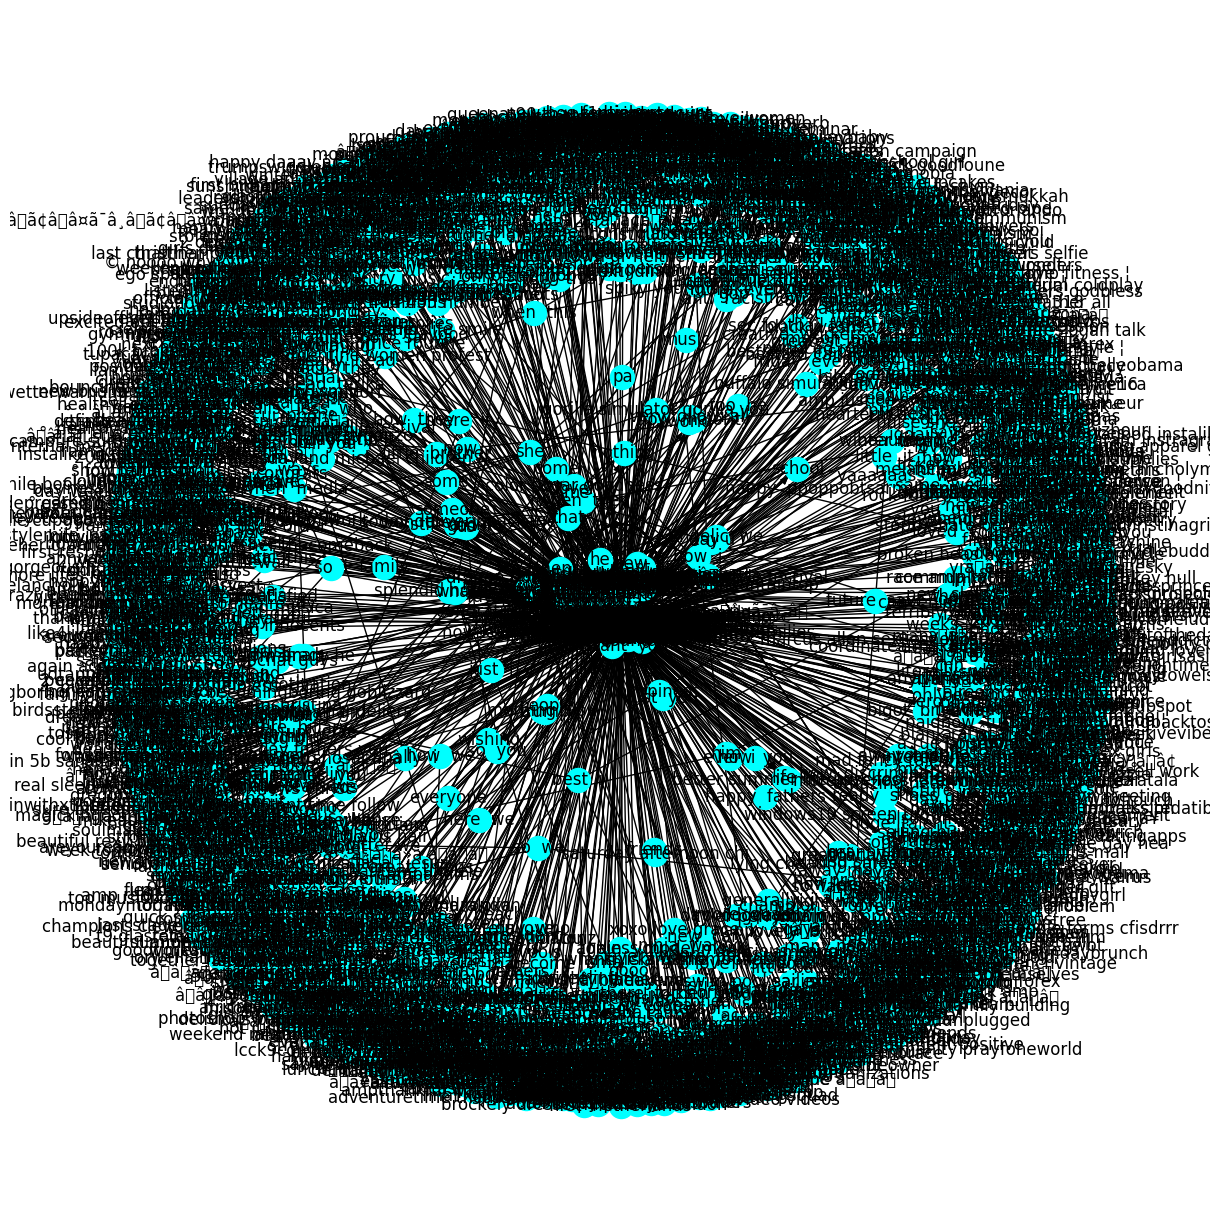

In [49]:
#Lets plot it using plotly
plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='Cyan', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

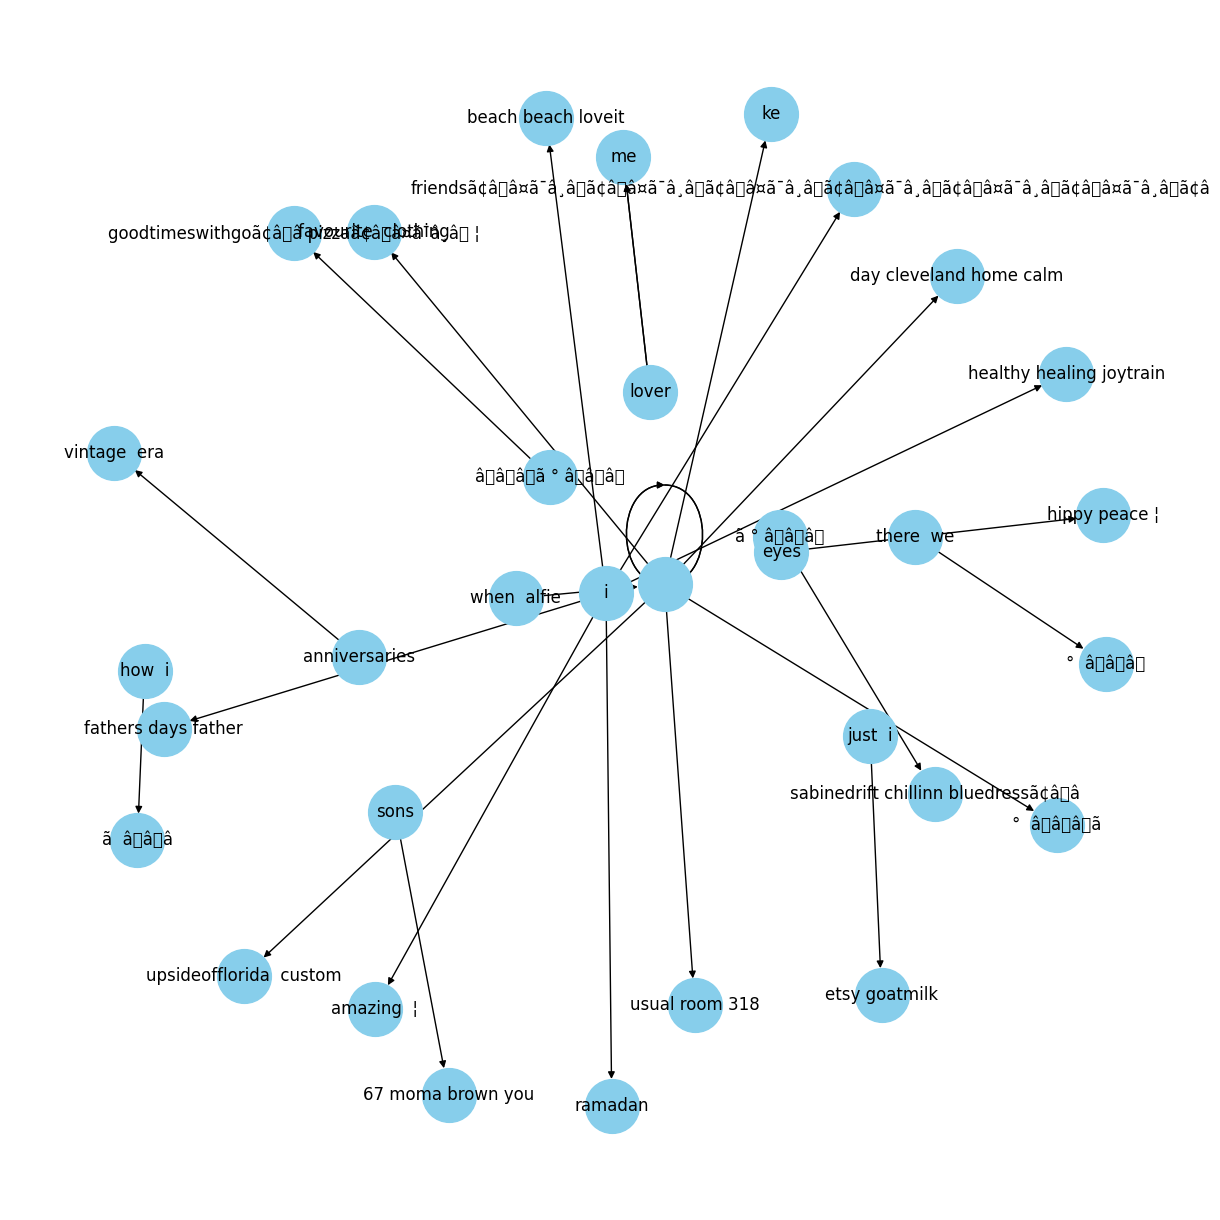

In [50]:
graph=nx.from_pandas_edgelist(graph_df[graph_df['predicate']=="love"], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()